# Sentiment Classifier - for JurisAI

In [1]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

  Using cached transformers-4.49.0-py3-none-any.whl.metadata (44 kB)
Using cached transformers-4.49.0-py3-none-any.whl (10.0 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.3
    Uninstalling transformers-4.48.3:
      Successfully uninstalled transformers-4.48.3
  Using cached accelerate-1.4.0-py3-none-any.whl.metadata (19 kB)
Using cached accelerate-1.4.0-py3-none-any.whl (342 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.3.0
    Uninstalling accelerate-1.3.0:
      Successfully uninstalled accelerate-1.3.0
  Using cached datasets-3.3.2-py3-none-any.whl.metadata (19 kB)
Using cached datasets-3.3.2-py3-none-any.whl (485 kB)
  Attempting uninstall: datasets
    Found existing installation: datasets 3.3.0
    Uninstalling datasets-3.3.0:
      Successfully uninstalled datasets-3.3.0


In [2]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/CorexDevelopment/juris/main/juris_dataset-ver4.csv")

In [3]:
# df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   desc      699 non-null    object
 1   label     699 non-null    int64 
 2   ipc_name  699 non-null    object
dtypes: int64(1), object(2)
memory usage: 16.5+ KB


In [4]:
df.isnull().sum()

desc        0
label       0
ipc_name    0
dtype: int64

In [5]:
df.describe()

,label
count,699.000000
mean,2.065808
std,1.504041
min,0.000000
25%,0.000000
50%,2.000000
75%,3.000000
max,4.000000


In [6]:
df['label'].value_counts()

label
2    224
0    198
4    171
3    103
1      3
Name: count, dtype: int64

# Dataset Analysis

In [7]:
import matplotlib.pyplot as plt

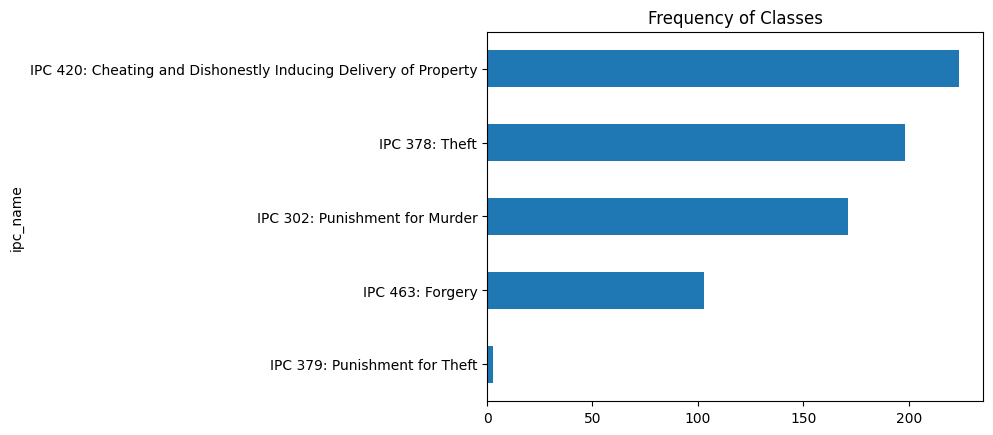

In [8]:
label_counts = df['ipc_name'].value_counts(ascending=True) # to show the label count in ascending order of their size
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

<Axes: title={'center': 'ok'}, xlabel='ipc_name'>

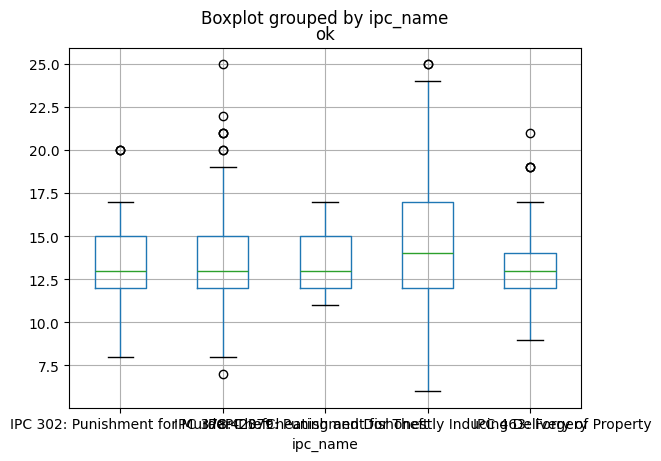

In [9]:
df['ok'] = df['desc'].str.split().apply(len)
df.boxplot("ok", by="ipc_name")

In [10]:
from transformers import AutoTokenizer
model_ckpt = "bert-base-uncased" # ckpt - checkpoint
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

desc = "I love ML! Tokenization is awesome."
encoded_text = tokenizer(desc)
print(encoded_text)

d:\Users\Vedanthc\anaconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'input_ids': [101, 1045, 2293, 19875, 999, 19204, 3989, 2003, 12476, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [11]:
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

# Data Loader and Train Test Split

In [12]:
df = df.dropna(subset=['ipc_name'])

In [13]:
df['ipc_name'].nunique()

5

In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.1, stratify=df['ipc_name'], random_state=42) # stratify - to maintain the class distribution in train and test set
test, validation = train_test_split(test, test_size=1/3, stratify=test['ipc_name'], random_state=42)

train.shape, test.shape, validation.shape

((629, 4), (46, 4), (24, 4))

In [15]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {   'train': Dataset.from_pandas(train, preserve_index=False),
        'test': Dataset.from_pandas(test, preserve_index=False),
        'validation': Dataset.from_pandas(validation, preserve_index=False)
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['desc', 'label', 'ipc_name', 'ok'],
        num_rows: 629
    })
    test: Dataset({
        features: ['desc', 'label', 'ipc_name', 'ok'],
        num_rows: 46
    })
    validation: Dataset({
        features: ['desc', 'label', 'ipc_name', 'ok'],
        num_rows: 24
    })
})

# Tokenization of the Emotion/Sentiment Data

In [16]:
dataset['train'][0], dataset['train'][1]

({'desc': 'A corporate spy is killed for trying to sell trade secrets to rival companies',
  'label': 4,
  'ipc_name': 'IPC 302: Punishment for Murder',
  'ok': 14},
 {'desc': 'A fraudster sells pirated software under the guise of original software',
  'label': 2,
  'ipc_name': 'IPC 420: Cheating and Dishonestly Inducing Delivery of Property',
  'ok': 11})

In [17]:
def tokenize(batch):
    temp=tokenizer(batch['desc'], padding=True, truncation=True, max_length=512) 
    # truncation - to truncate the text if it exceeds the max length
    # padding - to pad the text if it is less than the max length

    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 1037, 5971, 8645, 2003, 2730, 2005, 2667, 2000, 5271, 3119, 7800, 2000, 6538, 3316, 102], [101, 1037, 9861, 6238, 15187, 11304, 2094, 4007, 2104, 1996, 21980, 1997, 2434, 4007, 102, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]}


In [18]:
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None) 
# batch_size=None means it will tokenize all the data at once, as it is without any batch size


Map: 100%|██████████| 24/24 [00:00<00:00, 4799.66 examples/s]


In [19]:
# emotion_encoded
# label2id, id2label

label2id = { x['ipc_name']:x['label'] for x in dataset['train'] }
id2label = { v:k for k,v in label2id.items() } # value becomes key and key becomes value

label2id, id2label

({'IPC 302: Punishment for Murder': 4,
  'IPC 420: Cheating and Dishonestly Inducing Delivery of Property': 2,
  'IPC 378: Theft': 0,
  'IPC 463: Forgery': 3,
  'IPC 379: Punishment for Theft': 1},
 {4: 'IPC 302: Punishment for Murder',
  2: 'IPC 420: Cheating and Dishonestly Inducing Delivery of Property',
  0: 'IPC 378: Theft',
  3: 'IPC 463: Forgery',
  1: 'IPC 379: Punishment for Theft'})

# Model Building

In [20]:
from transformers import AutoModel
import torch

In [21]:
model = AutoModel.from_pretrained(model_ckpt)

In [22]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [23]:
# model.config.bad_words_ids 
model.config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [24]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.49.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [25]:
from transformers import AutoModelForSequenceClassification, AutoConfig 

num_labels = len(label2id)
# num_labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt, label2id = label2id, id2label = id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
device

device(type='cpu')

In [27]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [28]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "IPC 378: Theft",
    "1": "IPC 379: Punishment for Theft",
    "2": "IPC 420: Cheating and Dishonestly Inducing Delivery of Property",
    "3": "IPC 463: Forgery",
    "4": "IPC 302: Punishment for Murder"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "IPC 302: Punishment for Murder": 4,
    "IPC 378: Theft": 0,
    "IPC 379: Punishment for Theft": 1,
    "IPC 420: Cheating and Dishonestly Inducing Delivery of Property": 2,
    "IPC 463: Forgery": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id"

In [29]:
from transformers import TrainingArguments

batch_size = 64
training_dir = "juris_bert_base_train_dir"

training_args = TrainingArguments(
    output_dir = training_dir,
    overwrite_output_dir = True,
    num_train_epochs = 2,
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    evaluation_strategy = "epoch",
    disable_tqdm = False
)

d:\Users\Vedanthc\anaconda3\envs\myenv\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Building Compute Metrics using function

In [30]:
pip install evaluate

Note: you may need to restart the kernel to use updated packages.


In [31]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# (Another Method) Building Compute Metrics using sklearn

In [32]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred): # the pred parameter is automatically passed during training
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    
    return {"accuracy": acc, "f1": f1}

# Building Model and Trainer

In [33]:
from transformers import Trainer

trainer = Trainer(
    model = model, 
    args = training_args, 
    compute_metrics = compute_metrics,
    train_dataset = emotion_encoded['train'],
    eval_dataset = emotion_encoded['validation'],
    tokenizer = tokenizer,
)

C:\Users\Vedanthc\AppData\Local\Temp\ipykernel_29456\3920797464.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


# Model Evaluation

In [ ]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

{'test_loss': 1.1592103242874146,
 'test_accuracy': 0.6956521739130435,
 'test_f1': 0.6373760488176964,
 'test_runtime': 0.792,
 'test_samples_per_second': 58.081,
 'test_steps_per_second': 1.263}

In [ ]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.15      0.27        13
           2       0.61      0.93      0.74        15
           3       0.86      0.86      0.86         7
           4       0.71      0.91      0.80        11

    accuracy                           0.70        46
   macro avg       0.80      0.71      0.67        46
weighted avg       0.78      0.70      0.64        46



In [ ]:
label2id

{'IPC 302: Punishment for Murder': 4,
 'IPC 420: Cheating and Dishonestly Inducing Delivery of Property': 2,
 'IPC 378: Theft': 0,
 'IPC 463: Forgery': 3,
 'IPC 379: Punishment for Theft': 1}

# Plot Confusion Matrix

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

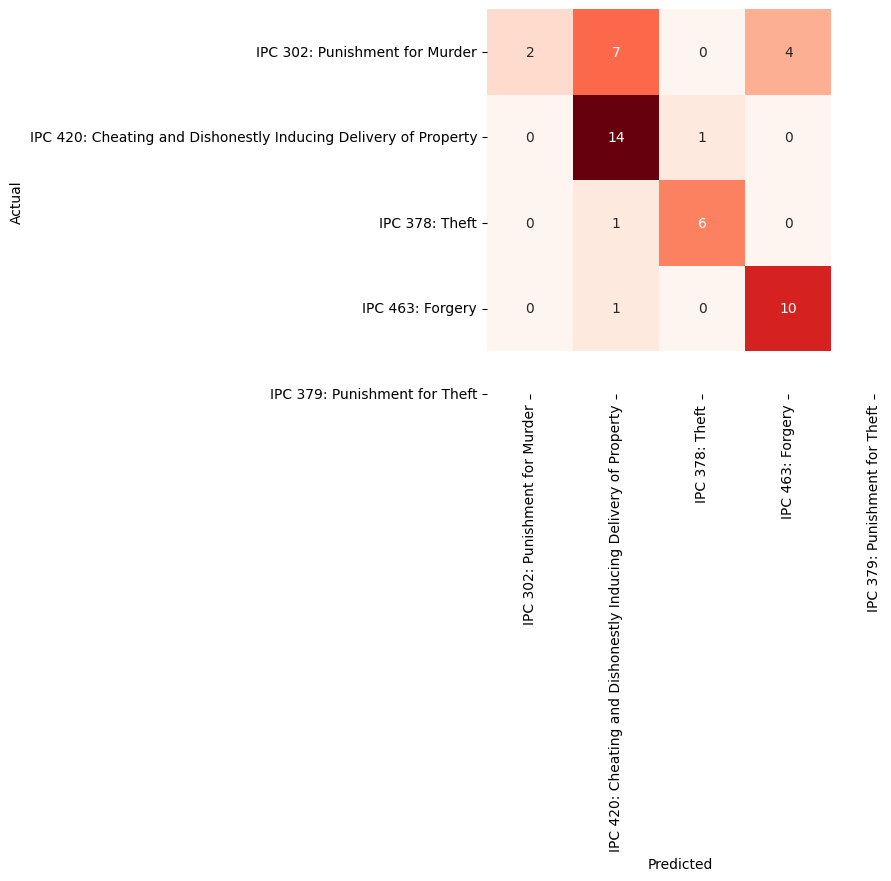

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Build Prediction Function and Store Model

In [ ]:
text = "A worker is killed by his colleagues after a dispute over salary payments"

def get_prediction(text):
    input_encoded = tokenizer (text, return_tensors='pt').to(device)
    with torch.no_grad():
        outputs = model(**input_encoded)
        
    logits = outputs.logits
    pred = torch.argmax(logits, dim=1).item()
    return id2label[pred]

get_prediction(text)

'IPC 302: Punishment for Murder'

In [ ]:
trainer.save_model("juris_bert-base-uncased-sentiment-model")

# Use Pipeline for Prediction

In [ ]:
from transformers import pipeline

classifier = pipeline('text-classification', model="juris_bert-base-uncased-sentiment-model")

classifier([text, 'A farmer submitted a fake loan waiver letter to avoid repayment of a loan'])

Device set to use cpu


[{'label': 'IPC 302: Punishment for Murder', 'score': 0.3392810523509979},
 {'label': 'IPC 463: Forgery', 'score': 0.31416553258895874}]